In [1]:
"""
ECGR 5105 - Intro to Machine Learning
Homework 5, Part 2
Phillip Harmon
""";


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import optim, nn
from collections import OrderedDict


In [3]:
#Normalization Functions
def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def denormalize(x, xmax, xmin):
    return (x * (xmax - xmin)) + xmin


In [4]:
#helper for plotting visualization of training data
def training_visual(loss_t, loss_v, model, loss_function, x, y):
    cost_function = loss_function()
    plt.rcParams["figure.figsize"] = (10,5)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Convergence of Training')
    plt.plot(range(1,len(loss_t) + 1),loss_t, color='blue', label='Training Loss')
    plt.plot(range(1,len(loss_t) + 1),loss_v, color='red', label='Validation Loss')
    plt.legend()
    plt.ylim([0.0,0.25])
    plt.show()
    print("Final Training Loss = {} | Final Validation Loss = {}".format(loss_t[-1], loss_v[-1]))
    
    x_n = normalize(x, x.max(0,keepdim=True)[0], x.min(0,keepdim=True)[0])
    y_n = normalize(y, y.max(0,keepdim=True)[0], y.min(0,keepdim=True)[0])
    print("Model MSE Loss for whole dataset = {}".format(cost_function(model(x_n) , y_n)))


In [5]:
#Training Loop Function
def training_loop(x_t, y_t, x_v, y_v, model, loss_function, optimizer, epochs):
    training_loss = []
    validation_loss = []
    
    cost_function = loss_function()
    
    for epoch in range(1, epochs + 1):
        
        loss_t = cost_function( model(x_t), y_t)
        loss_v = cost_function( model(x_v), y_v)
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        training_loss.append(float(loss_t))
        validation_loss.append(float(loss_v))
        
        if epoch <= 3 or epoch % 50 == 0:
            print('Epoch {} | Training Loss = {} | Validation Loss = {}'.format(epoch, loss_t, loss_v))
    
    return training_loss, validation_loss


In [6]:
#Prepare the inputs

#Read in the CSV into a dataframe
csvData = pd.read_csv("./Housing.csv")
csvCols = len(csvData.columns)
csvRows = len(csvData)

#Collect Data
dataLabels = ['price','area','bedrooms','bathrooms','stories','parking']
data = csvData[dataLabels]

y_raw = data.pop('price').values
x_raw = data.values

y_raw = torch.from_numpy(y_raw)
x_raw = torch.from_numpy(x_raw)

#Cleaning the inputs
x = normalize(x_raw, x_raw.max(0,keepdim=True)[0], x_raw.min(0,keepdim=True)[0])
y = normalize(y_raw, y_raw.max(0,keepdim=True)[0], y_raw.min(0,keepdim=True)[0])

#Train/Test Split
validation_percent = 0.2
split = int(validation_percent * x.shape[0])
shuffle_index = torch.randperm(x.shape[0])
index_t = shuffle_index[:-split]
index_v = shuffle_index[-split:]
x_t = x[index_t]
y_t = y[index_t]
x_v = x[index_v]
y_v = y[index_v]


In [7]:
operation = "Adam Optimizer, 1-layer net, LR=1e-3"
#Define Constructs
epochs = 200
learn_rate = 1e-3
neural_net = nn.Sequential(OrderedDict([
    ('Layer_1_Model', nn.Linear(5,8)),
    ('Layer_1_Activation', nn.Tanh()),
    ('Output_Model', nn.Linear(8,1))
    ]))
optimizer = optim.Adam(neural_net.parameters(), lr=learn_rate)


In [8]:
%%time
print(operation)
#Perform the Training
loss_t, loss_v = training_loop(
    epochs = epochs,
    optimizer = optimizer,
    model = neural_net,
    loss_function = nn.MSELoss,
    x_t = x_t,
    x_v = x_v,
    y_t = y_t,
    y_v = y_v)


Adam Optimizer, 1-layer net, LR=1e-3
Epoch 1 | Training Loss = 0.02815861813724041 | Validation Loss = 0.03302649408578873
Epoch 2 | Training Loss = 0.027996810153126717 | Validation Loss = 0.03276772424578667
Epoch 3 | Training Loss = 0.02789880894124508 | Validation Loss = 0.03260395675897598
Epoch 50 | Training Loss = 0.025389045476913452 | Validation Loss = 0.02988007850944996
Epoch 100 | Training Loss = 0.02530243806540966 | Validation Loss = 0.029824895784258842
Epoch 150 | Training Loss = 0.025298453867435455 | Validation Loss = 0.02982637658715248

G:\GprogramFiles\Conda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([436])) that is different to the input size (torch.Size([436, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
G:\GprogramFiles\Conda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch 200 | Training Loss = 0.025295691564679146 | Validation Loss = 0.02982373721897602
Wall time: 252 ms


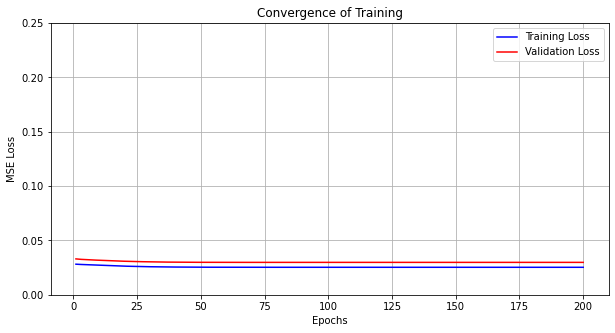

Final Training Loss = 0.025295691564679146 | Final Validation Loss = 0.02982373721897602
Model MSE Loss for whole dataset = 0.02620089240372181


G:\GprogramFiles\Conda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([545])) that is different to the input size (torch.Size([545, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [9]:
training_visual(
    loss_t = loss_t,
    loss_v = loss_v,
    model = neural_net,
    loss_function = nn.MSELoss,
    x = x_raw,
    y = y_raw)


In [10]:
operation = "SGD Optimizer, 1-layer net, LR=1e-3"
#Define Constructs
epochs = 200
learn_rate = 1e-2
neural_net = nn.Sequential(OrderedDict([
    ('Layer_1_Model', nn.Linear(5,8)),
    ('Layer_1_Activation', nn.Tanh()),
    ('Output_Model', nn.Linear(8,1))
    ]))
optimizer = optim.SGD(neural_net.parameters(), lr=learn_rate)


In [11]:
%%time
print(operation)
#Perform the Training
loss_t, loss_v = training_loop(
    epochs = epochs,
    optimizer = optimizer,
    model = neural_net,
    loss_function = nn.MSELoss,
    x_t = x_t,
    x_v = x_v,
    y_t = y_t,
    y_v = y_v)


SGD Optimizer, 1-layer net, LR=1e-3
Epoch 1 | Training Loss = 0.05540982633829117 | Validation Loss = 0.05919010937213898
Epoch 2 | Training Loss = 0.053433191031217575 | Validation Loss = 0.05722943693399429
Epoch 3 | Training Loss = 0.05161477252840996 | Validation Loss = 0.055426158010959625
Epoch 50 | Training Loss = 0.030822787433862686 | Validation Loss = 0.034938037395477295
Epoch 100 | Training Loss = 0.029939431697130203 | Validation Loss = 0.03414454683661461
Epoch 150 | Training Loss = 0.02950666844844818 | Validation Loss = 0.0337643064558506
Epoch 200 | Training Loss = 0.02912852168083191 | Validation Loss = 0.03342767059803009
Wall time: 163 ms


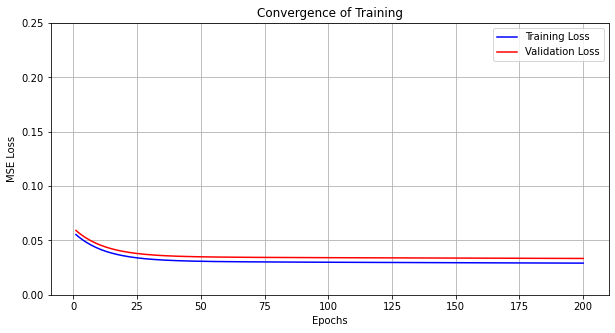

Final Training Loss = 0.02912852168083191 | Final Validation Loss = 0.03342767059803009
Model MSE Loss for whole dataset = 0.029983295127749443


In [12]:
training_visual(
    loss_t = loss_t,
    loss_v = loss_v,
    model = neural_net,
    loss_function = nn.MSELoss,
    x = x_raw,
    y = y_raw)


In [13]:
#Adam is Better!
#Let's try it for a bigger neural net!


In [14]:
operation = "Adam Optimizer, 3-layer net [in->8->13->5->out], LR=1e-3"
#Define Constructs
epochs = 200
learn_rate = 1e-3
neural_net = nn.Sequential(OrderedDict([
    ('Layer_1_Model', nn.Linear(5,8)),
    ('Layer_1_Activation', nn.Tanh()),
    ('Layer_2_Model', nn.Linear(8,13)),
    ('Layer_2_Activation', nn.Tanh()),
    ('Layer_3_Model', nn.Linear(13,5)),
    ('Layer_3_Activation', nn.Tanh()),
    ('Output_Model', nn.Linear(5,1))
    ]))
optimizer = optim.Adam(neural_net.parameters(), lr=learn_rate)


In [15]:
%%time
print(operation)
#Perform the Training
loss_t, loss_v = training_loop(
    epochs = epochs,
    optimizer = optimizer,
    model = neural_net,
    loss_function = nn.MSELoss,
    x_t = x_t,
    x_v = x_v,
    y_t = y_t,
    y_v = y_v)


Adam Optimizer, 3-layer net [in->8->13->5->out], LR=1e-3
Epoch 1 | Training Loss = 0.10475734621286392 | Validation Loss = 0.1098516434431076
Epoch 2 | Training Loss = 0.09903859347105026 | Validation Loss = 0.1041104719042778
Epoch 3 | Training Loss = 0.09356650710105896 | Validation Loss = 0.09861686825752258
Epoch 50 | Training Loss = 0.025937208905816078 | Validation Loss = 0.03057980164885521
Epoch 100 | Training Loss = 0.02541847713291645 | Validation Loss = 0.029992496594786644
Epoch 150 | Training Loss = 0.025350719690322876 | Validation Loss = 0.029882799834012985
Epoch 200 | Training Loss = 0.025321977213025093 | Validation Loss = 0.02984205074608326
Wall time: 317 ms


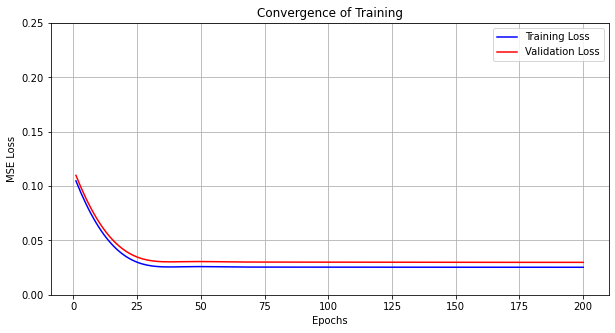

Final Training Loss = 0.025321977213025093 | Final Validation Loss = 0.02984205074608326
Model MSE Loss for whole dataset = 0.026226604357361794


In [16]:
training_visual(
    loss_t = loss_t,
    loss_v = loss_v,
    model = neural_net,
    loss_function = nn.MSELoss,
    x = x_raw,
    y = y_raw)


In [17]:
operation = "Adam Optimizer, 3-layer net [in->13->21->5->out], LR=1e-3"
#Define Constructs
epochs = 200
learn_rate = 1e-3
neural_net = nn.Sequential(OrderedDict([
    ('Layer_1_Model', nn.Linear(5,13)),
    ('Layer_1_Activation', nn.Tanh()),
    ('Layer_2_Model', nn.Linear(13,21)),
    ('Layer_2_Activation', nn.Tanh()),
    ('Layer_3_Model', nn.Linear(21,5)),
    ('Layer_3_Activation', nn.Tanh()),
    ('Output_Model', nn.Linear(5,1))
    ]))
optimizer = optim.Adam(neural_net.parameters(), lr=learn_rate)


In [18]:
%%time
print(operation)
#Perform the Training
loss_t, loss_v = training_loop(
    epochs = epochs,
    optimizer = optimizer,
    model = neural_net,
    loss_function = nn.MSELoss,
    x_t = x_t,
    x_v = x_v,
    y_t = y_t,
    y_v = y_v)


Adam Optimizer, 3-layer net [in->13->21->5->out], LR=1e-3
Epoch 1 | Training Loss = 0.08736804872751236 | Validation Loss = 0.09115060418844223
Epoch 2 | Training Loss = 0.08022507280111313 | Validation Loss = 0.08406160771846771
Epoch 3 | Training Loss = 0.07354738563299179 | Validation Loss = 0.07743436098098755
Epoch 50 | Training Loss = 0.025625130161643028 | Validation Loss = 0.03006667084991932
Epoch 100 | Training Loss = 0.0254366397857666 | Validation Loss = 0.02992679923772812
Epoch 150 | Training Loss = 0.025343503803014755 | Validation Loss = 0.029858145862817764
Epoch 200 | Training Loss = 0.025298304855823517 | Validation Loss = 0.02982133999466896
Wall time: 333 ms


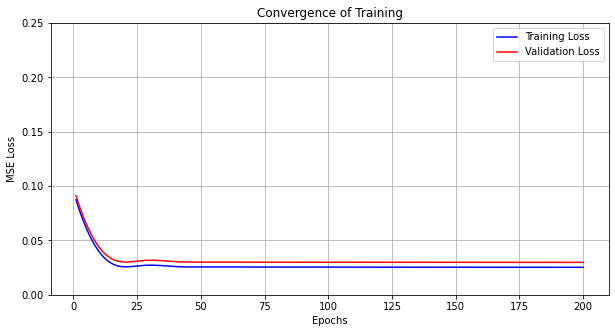

Final Training Loss = 0.025298304855823517 | Final Validation Loss = 0.02982133999466896
Model MSE Loss for whole dataset = 0.026202790439128876


In [19]:
training_visual(
    loss_t = loss_t,
    loss_v = loss_v,
    model = neural_net,
    loss_function = nn.MSELoss,
    x = x_raw,
    y = y_raw)
